## Code for 2018 CNN paper
experiment PACBED: H:/DE16/071618/S7, PACBED#35 (last one), CNN predicted to 42 layers, same as HAADF prediction
simulate PACBED:/srv/home/chenyu/STO_35nm_sim/42layers/*slice41* simulation library used to train CNN on MSCdata
CNN framework: 072618_extra_dense_retrain/attempt1_4_1

In [3]:
import os
import scipy.io as sio
import scipy.misc as smisc
import scipy.signal
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.transform import rescale, resize, downscale_local_mean
import csv

## Plots for figure 1

In [2]:
path = '/srv/home/chenyu/DEbackup/012119/S4/'
file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(path +  file_HAADF) as csvfile:
    file=csv.reader(open(path+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(150,150))

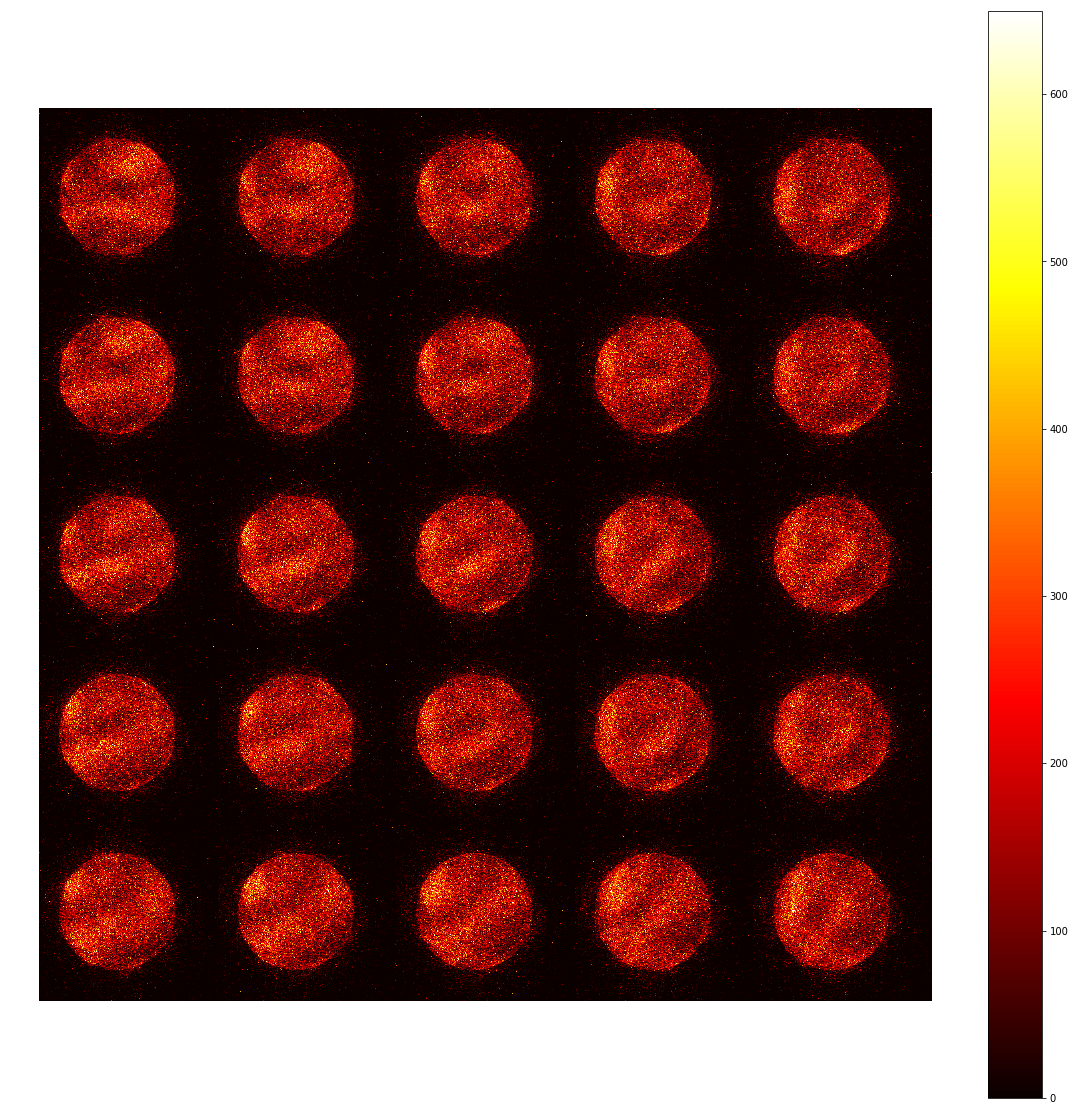

In [20]:
fig = plt.figure(figsize=(20,20))
plt.imshow(panel,cmap='hot')
plt.clim([0,650])
plt.axis('off')
plt.colorbar()

In [18]:
panel = np.zeros((512*5,512*5))
for irow in range(5):
    for icol in range(5):
        ifile = (irow + 100) * 150 + icol + 100 + 1
        frame = np.load(path + 'npy/S4' +'_'+format(ifile,'05')+'.npy')
        panel[irow*512:(irow+1)*512,icol*512:(icol+1)*512]=frame

(-0.5, 149.5, 149.5, -0.5)

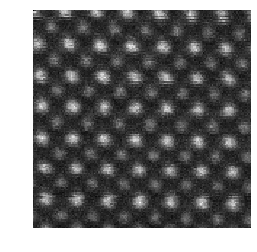

In [3]:
peaks_x = np.load(path + 'SrPeaks_x.npy')
peaks_y = np.load(path + 'SrPeaks_y.npy')
plt.imshow(HAADFarray,cmap='gray')
# plt.scatter(peaks_x,peaks_y,c='r')
plt.axis('off')

24.0


(-0.5, 511.5, 511.5, -0.5)

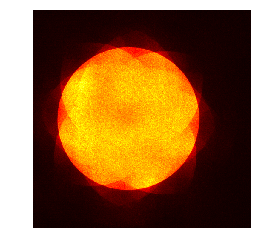

In [69]:
PACBED_stack = np.load(path + 'PACBED_stack_radius_7.npy')
plt.imshow(PACBED_stack[:,:,10],cmap='hot')
plt.clim([np.amin(PACBED_stack[:,:,10]),np.amax(PACBED_stack[:,:,10])*1.2])
thickness = np.load(path + 'SrPeaks_thickness.npy')
print(thickness[10])
plt.axis('off')

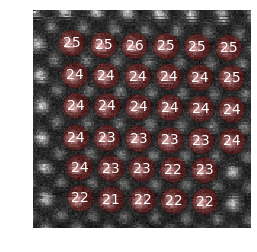

In [94]:
peaks_x = np.load(path + 'SrPeaks_x.npy')
peaks_y = np.load(path + 'SrPeaks_y.npy')
prediction = np.load(path + 'prediction.npy')
plt.imshow(HAADFarray,cmap = 'gray')
plt.axis('off')
for i in range(peaks_x.shape[0]):
    plt.text(peaks_x[i]-4, peaks_y[i]+2, int(prediction[i]/0.3905), bbox=dict(boxstyle='circle',facecolor='red', alpha=0.2)
             ,fontsize=14,color='white')

In [91]:
prediction

array([ 8.963271 ,  8.7975235,  8.733366 ,  8.827983 ,  8.517616 ,
        8.93982  ,  9.250195 ,  9.130265 ,  9.34049  ,  9.395803 ,
        9.539789 ,  9.154735 ,  9.331514 ,  9.274994 ,  9.208975 ,
        9.462813 ,  9.669645 ,  9.568294 ,  9.399574 ,  9.566287 ,
        9.623446 ,  9.675071 ,  9.557203 ,  9.625519 ,  9.891418 ,
        9.629783 ,  9.594624 ,  9.60338  ,  9.9529   , 10.139718 ,
       10.060514 , 10.084128 , 10.295475 , 10.146522 ], dtype=float32)

#### Load simulate 4D datacube

In [28]:
folder = '/srv/home/chenyu/STO_35nm_sim/42layers/'
base_name = 'STO_35nm_0_0_slice41'
base_ext = '_FPavg.npy'
array_size = (16,16)

imsize = (np.load(folder+base_name+'_X0_Y0'+base_ext)).shape
out_sz = array_size + imsize
output = np.zeros(out_sz,dtype=np.float32)
for x in range(array_size[0]):
        for y in range(array_size[1]):
            output[x,y,:,:] = np.load(folder+base_name+'_X'+str(x)+'_Y'+str(y)+base_ext)
output = np.squeeze(output)

#### Check 4D datacube by generate a ABF image
this ABF image has no source size included

In [85]:
def findSum(arr):
    return sum(map(sum,arr)) 

In [86]:
ABF = np.zeros(out_sz,dtype=np.float32)
y1,x1 = np.ogrid[-204:204, -204:204]
y2,x2 = np.ogrid[-204:204, -204:204]
mask1 = x1*x1 + y1*y1 <= 50*50
mask2 = x2*x2 + y2*y2 >= 25*25
mask_ABF = np.multiply(mask1, mask2)

ABF = np.zeros(out_sz[0:2],dtype=np.float32)
for x in range(array_size[0]):
        for y in range(array_size[1]):
            ABF[x,y] = findSum(np.multiply(output[x,y,:,:],mask_ABF))

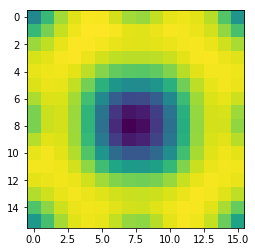

In [87]:
plt.imshow(ABF)

### Cross-validation accuracy

Text(47, 5, 'a')

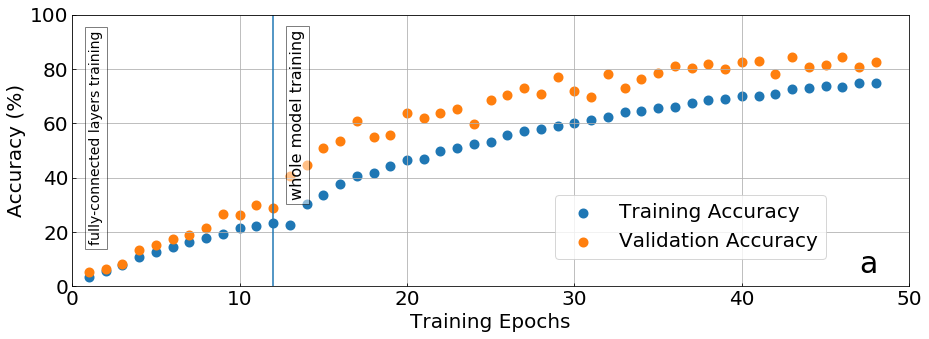

In [55]:
coarse_sample = '/srv/home/lerandc/CNN/models/072418_vgg16_softmax/attempt2/072418_vgg16_softmax.out'
train_acc = []
val_acc = []
with open(coarse_sample) as f:
    for line in f:
        data = line.split()
        if len(data) == 14:
            train_acc.append(float(data[7]))
            val_acc.append(float(data[13]))

epoch = np.linspace(1,len(train_acc),num=len(train_acc))
train_acc = np.array(train_acc) * 100
val_acc = np.array(val_acc) * 100

f, axarr = plt.subplots(figsize=(15,5))

l1 = axarr.scatter(epoch,train_acc, linewidth=4.0, label='Training Accuracy')
l2 = axarr.scatter(epoch,val_acc, linewidth=4.0, label='Validation Accuracy')
axarr.set_ylim([0,100])
axarr.set_xlim([0,50])
axarr.tick_params(labelsize=20,direction='in')
axarr.grid()
axarr.set_xlabel('Training Epochs',fontsize=20)
axarr.legend(bbox_to_anchor=(0.9, 0.1), loc='lower right', borderaxespad=0.,prop={'size': 20})
axarr.set_ylabel('Accuracy (%)',fontsize=20)

plt.text(1, 90, 'fully-connected layers training', rotation=90,fontsize=14,bbox=dict(facecolor='white', alpha=0.5))
plt.text(13, 90, 'whole model training', rotation=90,fontsize=16,bbox=dict(facecolor='white', alpha=0.5))

plt.axvline(x=12)


plt.text(47,5,'a',fontsize=30)

In [23]:
import pandas

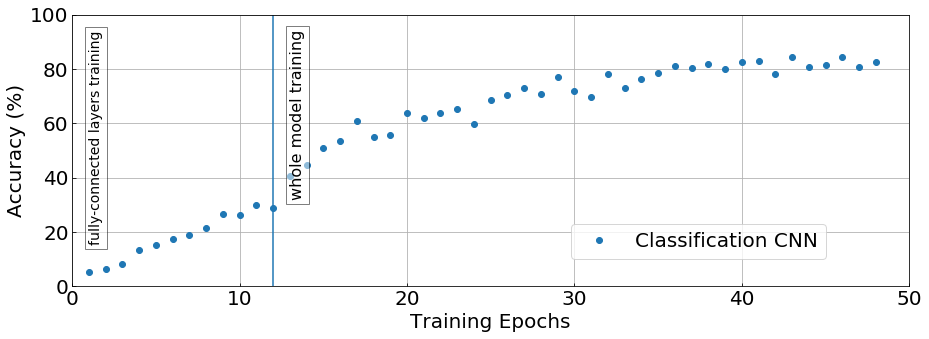

In [72]:
coarse_sample = '/srv/home/lerandc/CNN/models/072418_vgg16_softmax/attempt2/072418_vgg16_softmax.out'
train_acc = []
val_acc = []
with open(coarse_sample) as f:
    for line in f:
        data = line.split()
        if len(data) == 14:
            train_acc.append(float(data[7]))
            val_acc.append(float(data[13]))

epoch = np.linspace(1,len(train_acc),num=len(train_acc))
train_acc = np.array(train_acc) * 100
val_acc = np.array(val_acc) * 100

f, axarr = plt.subplots(figsize=(15,5))

# l1 = axarr.scatter(epoch,train_acc, linewidth=4.0, label='Training Accuracy')
l2 = axarr.plot(epoch,val_acc,'o', linewidth=4.0, label='Classification CNN')
axarr.set_ylim([0,100])
axarr.set_xlim([0,50])
axarr.tick_params(labelsize=20,direction='in')
axarr.grid()
axarr.set_xlabel('Training Epochs',fontsize=20)
axarr.legend(bbox_to_anchor=(0.9, 0.1), loc='lower right', borderaxespad=0.,prop={'size': 20})
axarr.set_ylabel('Accuracy (%)',fontsize=20)

plt.text(1, 90, 'fully-connected layers training', rotation=90,fontsize=14,bbox=dict(facecolor='white', alpha=0.5))
plt.text(13, 90, 'whole model training', rotation=90,fontsize=16,bbox=dict(facecolor='white', alpha=0.5))

plt.axvline(x=12)


# plt.text(47,5,'a',fontsize=30)

Text(36, 0.75, 'b')

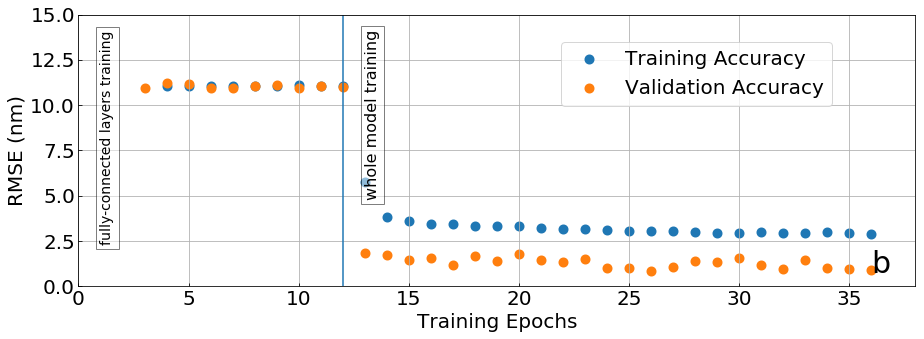

In [25]:
path = '/srv/home/chenyu/CNN/Regression/Coarse_CNN/PartiallyTraining/35nm/attempt_5/'
df = pandas.read_csv(path + 'training_1_bnfeature_log.csv')
train_acc = np.asarray(df['mean_squared_error'])
train_acc = train_acc[~np.isnan(train_acc)]
val_acc = np.asarray(df['val_mean_squared_error'])
val_acc = val_acc[~np.isnan(val_acc)]
bn_length = val_acc.shape[0]

df = pandas.read_csv(path + 'training_1_finetune_log.csv')
train_acc = np.concatenate((train_acc,np.asarray(df['mean_squared_error'])))
train_acc = train_acc[~np.isnan(train_acc)]
val_acc = np.concatenate((val_acc,np.asarray(df['val_mean_squared_error'])))
val_acc = val_acc[~np.isnan(val_acc)]

# convert fractional MSE to RMSE in nm

train_acc = np.sqrt(train_acc) * 36
val_acc = np.sqrt(val_acc) * 36

epoch = np.linspace(1,len(train_acc),num=len(train_acc))

f, axarr = plt.subplots(figsize=(15,5))

l1 = axarr.scatter(epoch,train_acc, linewidth=4.0, label='Training Accuracy')
l2 = axarr.scatter(epoch,val_acc, linewidth=4.0, label='Validation Accuracy')
axarr.set_ylim([0,15])
axarr.set_xlim([0,val_acc.shape[0]+2])
axarr.tick_params(labelsize=20,direction='in')
axarr.grid()
axarr.set_xlabel('Training Epochs',fontsize=20)
axarr.legend(bbox_to_anchor=(0.9, 0.9), borderaxespad=0.,prop={'size': 20})
axarr.set_ylabel('RMSE (nm)',fontsize=20)

plt.text(1, 13.5, 'fully-connected layers training', rotation=90,fontsize=14,bbox=dict(facecolor='white', alpha=0.5))
plt.text(13, 13.5, 'whole model training', rotation=90,fontsize=16,bbox=dict(facecolor='white', alpha=0.5))
plt.axvline(x=12)

plt.text(val_acc.shape[0],15/20,'b',fontsize=30)

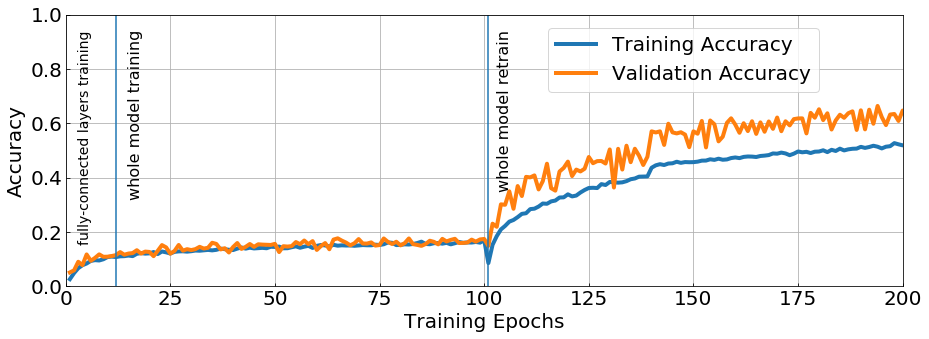

In [55]:
fine_sample = '/srv/home/lerandc/CNN/models/072618_vgg16_fine_sample_extra_dense/attempt1_4/072618_vgg16_extra_dense.out'
fine_sample_retrain = '/srv/home/lerandc/CNN/models/072618_vgg16_fine_sample_extra_dense_retrain/attempt1_4_1/072618_vgg16_extra_dense_retrain.out'
train_acc = []
val_acc = []
with open(fine_sample) as f:
    for line in f:
        data = line.split()
        if len(data) == 14:
            train_acc.append(float(data[7]))
            val_acc.append(float(data[13]))

with open(fine_sample_retrain) as f:
    for line in f:
        data = line.split()
        if len(data) == 14:
            train_acc.append(float(data[7]))
            val_acc.append(float(data[13]))
    

epoch = np.linspace(1,len(train_acc),num=len(train_acc))
train_acc = np.array(train_acc)
val_acc = np.array(val_acc)

f, axarr = plt.subplots(figsize=(15,5))

l1 = axarr.plot(epoch,train_acc, linewidth=4.0, label='Training Accuracy')
l2 = axarr.plot(epoch,val_acc, linewidth=4.0, label='Validation Accuracy')
axarr.set_ylim([0,1])
axarr.set_xlim([0,200])
axarr.tick_params(labelsize=20,direction='in')
axarr.grid()
axarr.set_xlabel('Training Epochs',fontsize=20)
axarr.set_ylabel('Accuracy',fontsize=20)
axarr.legend(bbox_to_anchor=(0.9,0.95), loc='upper right', borderaxespad=0.,prop={'size': 20})

plt.text(3, 0.9, 'fully-connected layers training', rotation=90,fontsize=14)
plt.text(15, 0.9, 'whole model training', rotation=90,fontsize=16)
plt.text(103, 0.9, 'whole model retrain', rotation=90,fontsize=16)


plt.axvline(x=12)
plt.axvline(x=101)

## Fig 5 plot, table of different sourcesize and integration radius

58.0


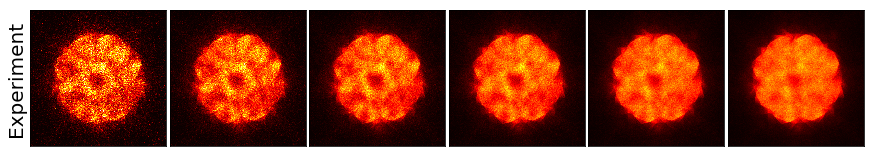

In [76]:
# Plot experiment data with different integration radii
f, axarr = plt.subplots(1, 6, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15,2.5))
exp_folder = '/srv/home/chenyu/DEbackup/033119/S8/'
for i in range(6):
    datacube = np.load(exp_folder + 'PACBED_stack_radius_' + str(i+1) + '.npy')
    axarr[i].imshow(datacube[:,:,10],cmap='hot',clim=[0,250])
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    if i == 0:
        axarr[i].set_ylabel('Experiment', fontsize=20)
        
thickness = np.load(exp_folder + 'SrPeaks_thickness.npy')
thickness = thickness[8]
print(thickness)   # thickness in unit cells

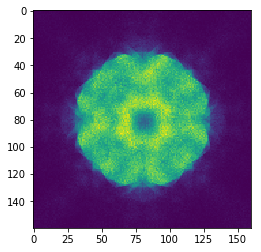

In [79]:
path = '/srv/home/chenyu/CNN/Data/STO_50nm_PACBED/0_0/'
sim_PACBED = np.load('/srv/home/chenyu/CNN/Data/STO_50nm_PACBED/0_0/STO_22_0_0_6.npy')
plt.imshow(sim_PACBED)

## Fig.3 Match simulation with sourcesize to experiment and put inside one plot
#### Fine sampling CNN, 5x accurate predictions + 1x wrong prediction
<br>Index start from zero.
<br>Series Ind  CNN    HAADF
<br>S4     #4   77.1   76UC, 76 is HAADF prediction
<br>S5     #17  61.3   60UC
<br>S7     #5   41.6   42UC
<br>S9     #14  26.6   25UC
<br>S10    #3   11.6   11UC
<br>
<br>S5     #1   63.7   56UC 7uc difference
<br> Simulation zero disk diameter: 94px, experiment full size diameter: 416px. Reiszie by a factor of 94/416.

In [34]:
temp = np.load('/srv/home/chenyu/DEbackup/2018/071618/S5/prediction_r6_coarse_regression.npy')
print(temp[7])

24.165503


In [4]:
def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

In [8]:
sim_path = '/srv/home/lerandc/outputs/718_STO/0_0/raw_output/' # use the old simulation with 1uc increment
                                                               # new simulation is more coarse with 2uc increment
exp_path = '/srv/home/chenyu/DEbackup/2018/071618/'
array_size = (16,16)
examples = np.matrix([[4,4,77],
                    [5,17,61],
                    [7,5,42],
                    [9,14,27],
                    [10,3,11],
                     [5,1,64],
                     [5,1,56]])

# load example experiment Sr-PACBED
datacube = sio.loadmat(exp_path +'S' +str(examples[0,0]) + '/SrPACBED_Stack_R6.mat')
datacube = datacube.get('PACBED_stack')

# manually enter simulation library size
out_sz = (16,16,408,408)

exp_length = examples.shape[0]
sim_lib = np.zeros((out_sz[2],out_sz[3],exp_length))
exp_lib = np.zeros((116,116, exp_length))

source_size = 110
px_size = 20
sigma = (source_size/px_size)/(2.355)

y1,x1 = np.ogrid[-8:8, -8:8]
y2,x2 = np.ogrid[-8:8, -8:8]
mask = x1*x1 + y1*y1 <= 5*5


for i in range(examples.shape[0]):
    # 6 px radius is used for experiment
    datacube = sio.loadmat(exp_path +'S' +str(examples[i,0]) + '/SrPACBED_Stack_R6.mat')
    print(exp_path +'S' +str(examples[i,0]) + '/SrPACBED_Stack_R6.mat')
    exp = datacube.get('PACBED_stack')
    exp = exp[:,:,examples[i,1]]/(19675223*0.952)
    exp_rescale = rescale(exp, 94.0 / 416.0)
    exp_rescale = exp_rescale / np.sum(exp_rescale) * np.sum(exp)
    exp_lib[:,:,i] = exp_rescale
    
    base_name = 'STO_35nm_0_0_slice' + str(examples[i,2]-1)
    base_ext = '_FPavg.npy'

    # load original simulation 4D-data
    output = np.zeros(out_sz,dtype=np.float32)
    for x in range(array_size[0]):
            for y in range(array_size[1]):
                output[x,y,:,:] = np.squeeze(np.load(sim_path+base_name+'_X'+str(x)+'_Y'+str(y)+base_ext))
                
    output = np.squeeze(output)
    result = np.zeros(out_sz,dtype=np.float32)
    
    kernel = gaussKernel(sigma,array_size[0])
    fkernel = np.fft.fft2(kernel)
    
    for k in range(out_sz[2]):
            for l in range(out_sz[3]):
                #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
                result[:,:,k,l] = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(output[:,:,k,l]))).real
                #result[:,:,k,l] = scipy.signal.convolve2d(output[:,:,k,l],fkernel,boundary='symm', mode='same')

    for x in range(out_sz[0]):
        for y in range(out_sz[1]):
            if mask[x,y]!=0:
                sim_lib[:,:,i] = sim_lib[:,:,i] + result[x,y,:,:]
                
    sim_lib[:,:,i] = sim_lib[:,:,i]/np.sum(mask)


/srv/home/chenyu/DEbackup/2018/071618/S4/SrPACBED_Stack_R6.mat


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/srv/home/chenyu/DEbackup/2018/071618/S5/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S7/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S9/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S10/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S5/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S5/SrPACBED_Stack_R6.mat


In [9]:
exp_lib[:,:,3] = exp_lib[:,:,3]/290

0.8876108505623165 0.8733302540296206
0.8910065451524848 0.8913864577737032
0.909208538559236 0.9151376725438571
0.9001228194365805 0.9372551551571942
0.967920876142826 0.9596919075706036
0.897438735086175 0.8877762696113812


<function matplotlib.pyplot.show(*args, **kw)>

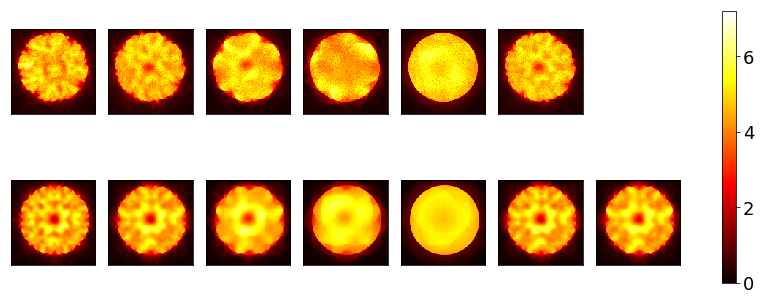

In [10]:
sim_min = sim_lib.min()
sim_max = sim_lib.max()

f, axarr = plt.subplots(2, 7, gridspec_kw = {'wspace':0.15, 'hspace':0.25}, figsize=(15,5))
for icol in range(6):
    im = axarr[1,icol].imshow(sim_lib[150:266,145:261,icol],cmap='hot',clim=[0,0.00018])
    axarr[1,icol].set_xticks([])
    axarr[1,icol].set_yticks([])

    im = axarr[0,icol].imshow(exp_lib[:,:,icol]/0.92,cmap='hot',clim=[0,0.00018])
    axarr[0,icol].set_xticks([])
    axarr[0,icol].set_yticks([])
    print(np.sum(exp_lib[:,:,icol]/0.92),np.sum(sim_lib[150:266,145:261,icol]))
    
axarr[1,6].imshow(sim_lib[150:266,145:261,6],cmap='hot',clim=[0,0.00018])
axarr[1,6].set_xticks([])
axarr[1,6].set_yticks([])
axarr[0,6].axis('off')

cbar = f.colorbar(im, ax=axarr.ravel().tolist())
cbar.ax.tick_params(labelsize=18) 
cbar.ax.set_yticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16', '18'])  # vertically oriented colorbar
# cbar.set_label('Beam Fraction (10^-5)', rotation=270)

plt.show

In [11]:
sim_path = '/srv/home/lerandc/outputs/712_STO/0_0/raw_output/'
exp_path = '/srv/home/chenyu/DEbackup/2018/071618/'

examples = np.matrix([[1,15,30],
                    [3,5,22],
                    [5,13,12],
                    [9,9,5],
                    [10,13,1],
                    [3,4,30],
                    [3,4,20]])

# load example experiment Sr-PACBED
datacube = sio.loadmat(exp_path +'S' +str(examples[0,0]) + '/SrPACBED_Stack_R6.mat')
fields = sio.whosmat(exp_path +'S' +str(examples[0,0]) + '/SrPACBED_Stack_R6.mat')
datacube = datacube[fields[0][0]]

# manually enter simulation library size
out_sz = (16,16,408,408)

exp_length = examples.shape[0]
sim_lib = np.zeros((out_sz[2],out_sz[3],exp_length))
exp_lib = np.zeros((116,116, exp_length))

source_size = 110
px_size = 20
sigma = (source_size/px_size)/(2.355)

y1,x1 = np.ogrid[-8:8, -8:8]
y2,x2 = np.ogrid[-8:8, -8:8]
mask = x1*x1 + y1*y1 <= 5*5


for i in range(examples.shape[0]):
    # 6 px radius is used for experiment
    datacube = sio.loadmat(exp_path +'S' +str(examples[i,0]) + '/SrPACBED_Stack_R6.mat')
    fields = sio.whosmat(exp_path +'S' +str(examples[i,0]) + '/SrPACBED_Stack_R6.mat')
    print(exp_path +'S' +str(examples[i,0]) + '/SrPACBED_Stack_R6.mat')
    exp = datacube[fields[0][0]]
    
    exp = exp[:,:,examples[i,1]]/(19675223*0.952)
    exp_rescale = rescale(exp, 94.0 / 416.0)
    exp_rescale = exp_rescale / np.sum(exp_rescale) * np.sum(exp)
    exp_lib[:,:,i] = exp_rescale
    
    base_name = 'STO_thick_FP16_tilt_0_0_slice' + str(examples[i,2]-1)
    base_ext = '_FPavg.npy'

    # load original simulation 4D-data
    output = np.zeros(out_sz,dtype=np.float32)
    for x in range(array_size[0]):
            for y in range(array_size[1]):
                output[x,y,:,:] = np.squeeze(np.load(sim_path+base_name+'_X'+str(x)+'_Y'+str(y)+base_ext))
                
    output = np.squeeze(output)
    result = np.zeros(out_sz,dtype=np.float32)
    
    kernel = gaussKernel(sigma,array_size[0])
    fkernel = np.fft.fft2(kernel)
    
    for k in range(out_sz[2]):
            for l in range(out_sz[3]):
                #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
                result[:,:,k,l] = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(output[:,:,k,l]))).real
                #result[:,:,k,l] = scipy.signal.convolve2d(output[:,:,k,l],fkernel,boundary='symm', mode='same')

    for x in range(out_sz[0]):
        for y in range(out_sz[1]):
            if mask[x,y]!=0:
                sim_lib[:,:,i] = sim_lib[:,:,i] + result[x,y,:,:]
                
    sim_lib[:,:,i] = sim_lib[:,:,i]/np.sum(mask)


/srv/home/chenyu/DEbackup/2018/071618/S1/SrPACBED_Stack_R6.mat


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/srv/home/chenyu/DEbackup/2018/071618/S3/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S5/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S9/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S10/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S3/SrPACBED_Stack_R6.mat
/srv/home/chenyu/DEbackup/2018/071618/S3/SrPACBED_Stack_R6.mat


0.760167858743008 0.7859869100772383
0.8249559694993108 0.8247020902187956
0.8932473433263932 0.880178186688204
0.8918430148121979 0.9317786804686631
0.9633626471231032 0.9697801447089374
0.822906256844372 0.7859869100772383


<function matplotlib.pyplot.show(*args, **kw)>

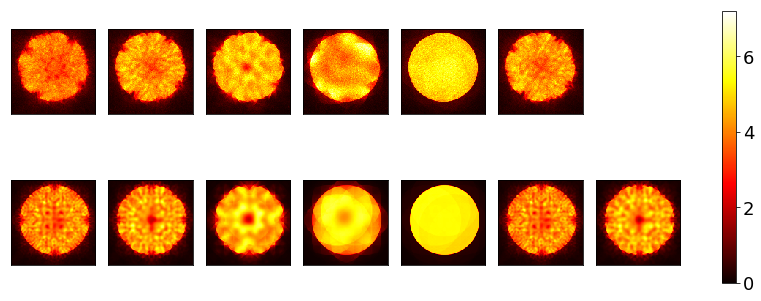

In [13]:
sim_min = sim_lib.min()
sim_max = sim_lib.max()
exp_lib[:,:,3] = exp_lib[:,:,3]/290
f, axarr = plt.subplots(2, 7, gridspec_kw = {'wspace':0.15, 'hspace':0.25}, figsize=(15,5))
for icol in range(6):
    im = axarr[1,icol].imshow(sim_lib[150:266,145:261,icol],cmap='hot',clim=[0,0.00018])
    axarr[1,icol].set_xticks([])
    axarr[1,icol].set_yticks([])

    im = axarr[0,icol].imshow(exp_lib[:,:,icol]/0.92,cmap='hot',clim=[0,0.00018])
    axarr[0,icol].set_xticks([])
    axarr[0,icol].set_yticks([])
    print(np.sum(exp_lib[:,:,icol]/0.92),np.sum(sim_lib[150:266,145:261,icol]))
    
axarr[1,6].imshow(sim_lib[150:266,145:261,6],cmap='hot',clim=[0,0.00018])
axarr[1,6].set_xticks([])
axarr[1,6].set_yticks([])
axarr[0,6].axis('off')

cbar = f.colorbar(im, ax=axarr.ravel().tolist())
cbar.ax.tick_params(labelsize=18) 
cbar.ax.set_yticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16', '18'])  # vertically oriented colorbar
# cbar.set_label('Beam Fraction (10^-5)', rotation=270)

plt.show

### Generate Sr PACBED from center using 7.5px integration radius and consider different source size
the center is placed between (8,8) and (9,9), which makes it hard to define an exact center

In [88]:
y1,x1 = np.ogrid[-8:8, -8:8]
y2,x2 = np.ogrid[-8:8, -8:8]
mask_stack = np.zeros([output.shape[0],output.shape[1],6],dtype = np.float32)
for radius in range(1,7):
    mask_stack[:,:,radius-1] = x1*x1 + y1*y1 <= radius*radius

Text(0.5,1,'Integration window visulize on ABF with no source size')

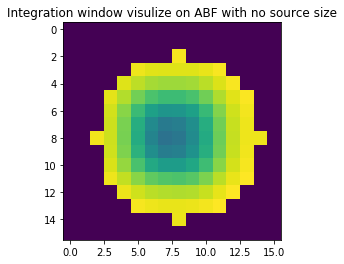

In [89]:
plt.imshow(np.multiply(ABF,mask_stack[:,:,5]))
plt.title('Integration window visulize on ABF with no source size')

In [297]:
sourcesize_range = [30,60,90,120,150]
PACBED_conv = np.zeros([output.shape[2],output.shape[3],(len(sourcesize_range)+1)*mask_stack.shape[2]],dtype=np.float32)
ABF_stack = np.zeros([output.shape[0],output.shape[1],(len(sourcesize_range)+1)*mask_stack.shape[2]],dtype = np.float32)
kernel_list = np.zeros([output.shape[0],output.shape[1],len(sourcesize_range)],dtype = np.float32)
px_size = 20
index = 0

# first run the case for zero source size 
for mask_index in range(mask_stack.shape[2]):

    kx,ky = output.shape[2:4]
            
    for x in range(ABF.shape[0]):
        for y in range(ABF.shape[1]):
            # ABF image shouldn't change with integration radius, this is only for santity check
            ABF_stack[x,y,index] = findSum(np.multiply(output[x,y,:,:],mask_ABF))
            if mask_stack[x,y,mask_index]!=0:
                PACBED_conv[:,:,index] = PACBED_conv[:,:,index] + output[x,y,:,:]
    PACBED_conv[:,:,index] = PACBED_conv[:,:,index]/np.sum(mask_stack[:,:,mask_index])
    index = index +1

for source_size in sourcesize_range:
    
    sigma = (source_size/px_size)/(2.355)
    kernel = gaussKernel(sigma,ABF.shape[0])
    #kernel_list[:,:,index-1] = kernel
    fkernel = np.fft.fft2(kernel)
    
    for mask_index in range(mask_stack.shape[2]):
    
        kx,ky = output.shape[2:4]
        #initialize result array
        result = np.zeros(out_sz,dtype=np.float32)
        result = np.squeeze(result)
        #print(str(sigma))
        #print(str(index))
        #print(result.shape)

        for k in range(kx):
            for l in range(ky):
                #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
                result[:,:,k,l] = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(output[:,:,k,l]))).real
                #result[:,:,k,l] = scipy.signal.convolve2d(output[:,:,k,l],fkernel,boundary='symm', mode='same')

        for x in range(ABF.shape[0]):
            for y in range(ABF.shape[1]):
                # ABF image shouldn't change with integration radius, this is only for santity check
                ABF_stack[x,y,index] = findSum(np.multiply(result[x,y,:,:],mask_ABF))
                if mask_stack[x,y,mask_index]!=0:
                    PACBED_conv[:,:,index] = PACBED_conv[:,:,index] + result[x,y,:,:]
        PACBED_conv[:,:,index] = PACBED_conv[:,:,index]/np.sum(mask_stack[:,:,mask_index])

        index = index + 1



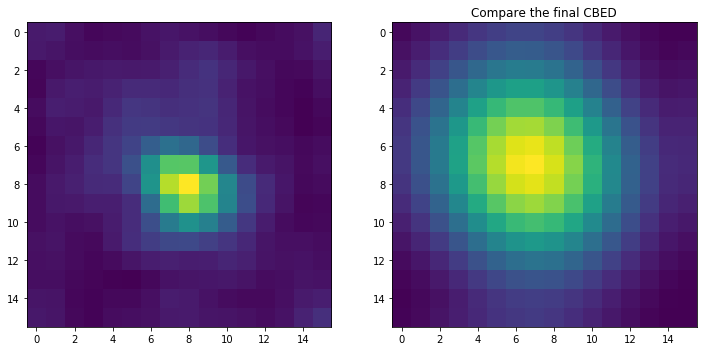

In [186]:
fig=plt.figure(figsize=(12, 6))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(output[:,:,k,l])
fig.add_subplot(rows, columns, 2)
plt.imshow(result[:,:,k,l])
plt.title('Compare the final CBED')
plt.show()


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


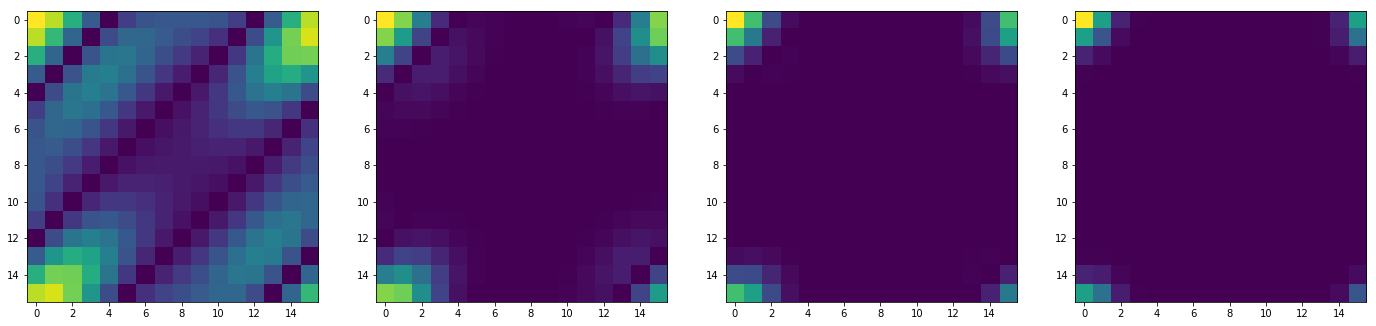

In [187]:
index = 0
for source_size in sourcesize_range:
    result = np.zeros(out_sz,dtype=np.float32)
    sigma = (source_size/px_size)/(2.355)
    kernel = gaussKernel(sigma,ABF.shape[0])
    kernel_list[:,:,index] = np.fft.fft2(kernel)
    index = index + 1
    
fig=plt.figure(figsize=(24, 6))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(abs(kernel_list[:,:,i-1]))
plt.show()

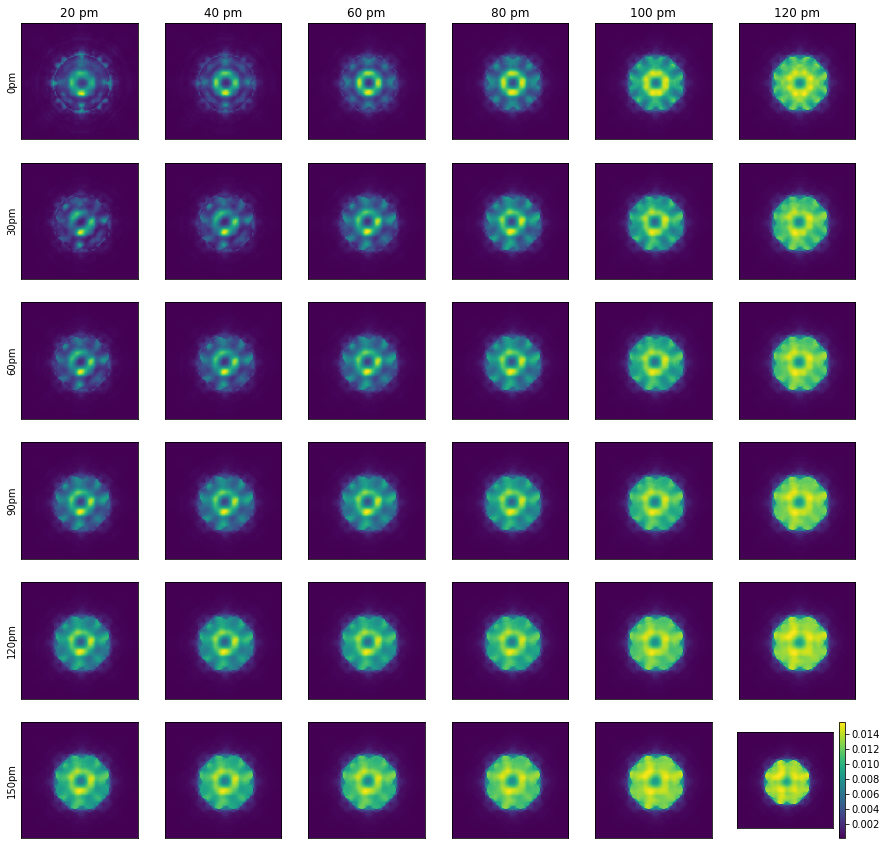

In [293]:
#f, axarr = plt.subplots(6, 6, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15,15))
fig = plt.figure(figsize=(15,15))

for irow in range(6):
    for icol in range(6):
        fig.add_subplot(6,6,irow*6+icol+1)
        fig.subplots_adjust(wspace=None,hspace=None)
        plt.imshow(PACBED_conv[100:300,100:300,irow*6+icol])
        plt.xticks([])
        plt.yticks([])
        if irow == 0:
            plt.title(str((icol+1)*20) + ' pm')
        if icol == 0 and irow !=0:
            plt.ylabel(str(sourcesize_range[irow-1]) + 'pm')
        if icol == 0 and irow == 0:
            plt.ylabel('0pm')

plt.colorbar()
plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

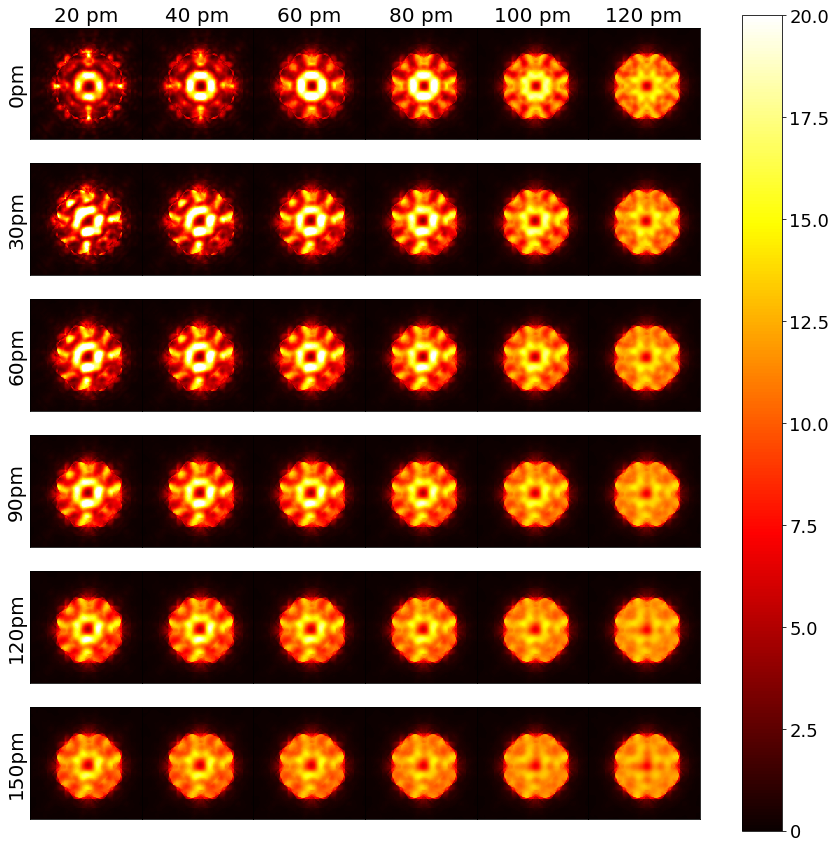

In [308]:
f, axarr = plt.subplots(6, 6, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15,15))
sim_max = PACBED_conv.max()
sim_min = PACBED_conv.min()
for irow in range(6):
    for icol in range(6):
        im = axarr[irow,icol].imshow(PACBED_conv[120:280,120:280,irow*6+icol],cmap='hot',clim=[0,0.0002])
        axarr[irow,icol].set_xticks([])
        axarr[irow,icol].set_yticks([])
        axarr[irow,icol].set_aspect('equal')
        if irow == 0:
            axarr[irow,icol].set_title(str((icol+1)*20) + ' pm', fontsize=20)
        if icol == 0 and irow !=0:
            axarr[irow,icol].set_ylabel(str(sourcesize_range[irow-1]) + 'pm', fontsize=20)
        if icol == 0 and irow == 0:
            axarr[irow,icol].set_ylabel('0pm',fontsize=20)
            
cbar = fig.colorbar(im, ax=axarr.ravel().tolist())
cbar.ax.tick_params(labelsize=18) 
cbar.ax.set_yticklabels(['0', '2.5', '5.0', '7.5', '10.0', '12.5', '15.0', '17.5', '20.0'])  # vertically oriented colorbar
# cbar.set_label('Beam Fraction (10^-5)', rotation=270)
        
plt.show

Plot experiment image corresponding to each integration radius

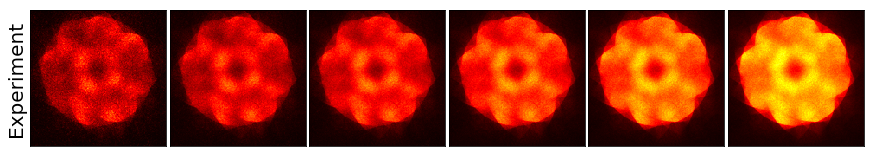

In [25]:
f, axarr = plt.subplots(1, 6, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15,2.5))
exp_folder = '/srv/home/chenyu/STO_35nm_sim/EXP/'
for i in range(6):
    datacube = sio.loadmat(exp_folder + 'SrPACBED_Stack_R' + str(i+1) + '_resize.mat')
    datacube = datacube.get('PACBED_stack_resize')
    datacube = datacube / (i+1) / (i+1)
    axarr[i].imshow(datacube[:,:,34],cmap='hot',clim=[0,1400])
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    if i == 0:
        axarr[i].set_ylabel('Experiment', fontsize=20)

Plot reconstructed ABF image for each case, ABF image doesn't change with window size (each row is the same), calculation is accurate

<function matplotlib.pyplot.show(*args, **kw)>

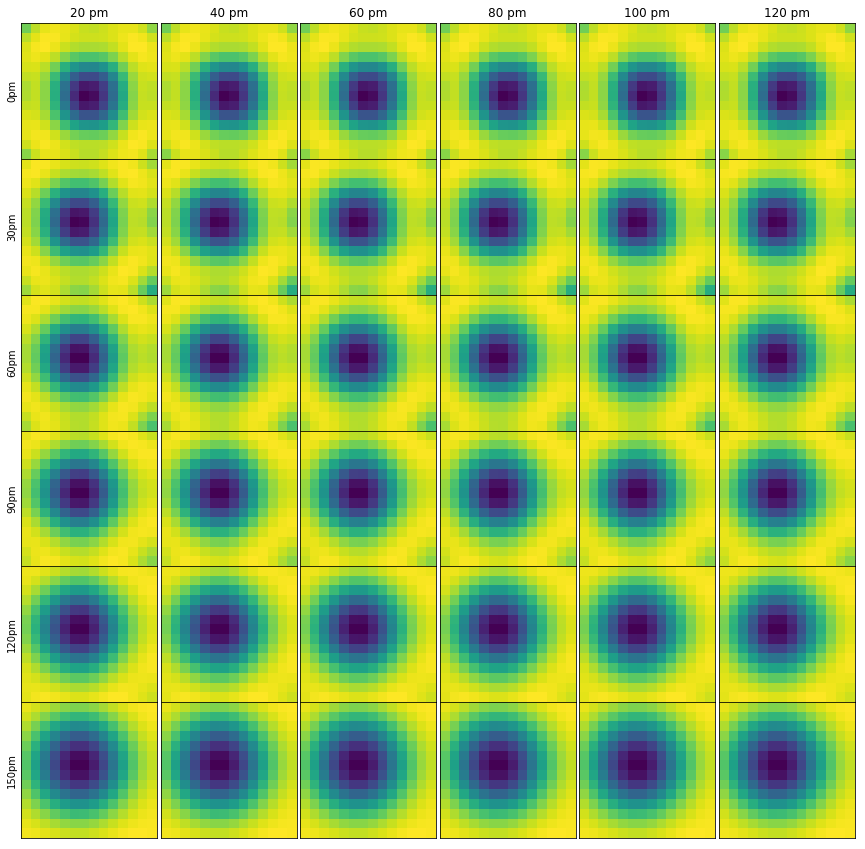

In [163]:
f, axarr = plt.subplots(6, 6, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15,15))
for irow in range(6):
    for icol in range(6):
        axarr[irow,icol].imshow(ABF_stack[1:15,1:15,irow*6+icol])
        axarr[irow,icol].set_xticks([])
        axarr[irow,icol].set_yticks([])
        ax1.set_aspect('equal')
        if irow == 0:
            axarr[irow,icol].set_title(str((icol+1)*20) + ' pm')
        if icol == 0 and irow !=0:
            axarr[irow,icol].set_ylabel(str(sourcesize_range[irow-1]) + 'pm')
        if icol == 0 and irow == 0:
            axarr[irow,icol].set_ylabel('0pm')
        
plt.show

nparray can do elementwise multiplication directly using *, works the same as np.multiply